In [3]:
!pip install python-louvain


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import networkx as nx
import matplotlib.pyplot as plt
import community as community_louvain
from networkx.algorithms.community import greedy_modularity_communities
from itertools import combinations
from collections import Counter
import numpy as np


In [5]:
G = nx.karate_club_graph()

print("Nodes:", G.number_of_nodes())
print("Edges:", G.number_of_edges())


Nodes: 34
Edges: 78


In [6]:
ground_truth = {}

for node, data in G.nodes(data=True):
    ground_truth[node] = data["club"]   # "Mr. Hi" or "Officer"

# Convert to numeric labels
gt_labels = {n: (0 if club == "Mr. Hi" else 1) for n, club in ground_truth.items()}


In [7]:
louvain_labels = community_louvain.best_partition(G)


In [8]:
fg_comms = list(greedy_modularity_communities(G))

# Convert to flat dict of node → community ID
fg_labels = {}
for i, comm in enumerate(fg_comms):
    for node in comm:
        fg_labels[node] = i


In [9]:
def plot_communities(G, labels, title):
    communities = set(labels.values())
    colors = plt.cm.tab20(np.linspace(0, 1, len(communities)))

    color_map = []
    for node in G.nodes():
        color_map.append(colors[labels[node]])

    plt.figure(figsize=(7, 6))
    pos = nx.spring_layout(G, seed=42)
    nx.draw_networkx(G, pos,
                     node_color=color_map,
                     with_labels=True,
                     node_size=350,
                     font_size=8)
    plt.title(title)
    plt.show()


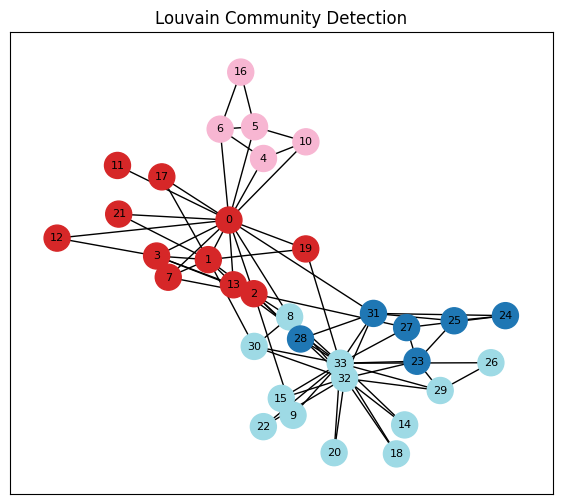

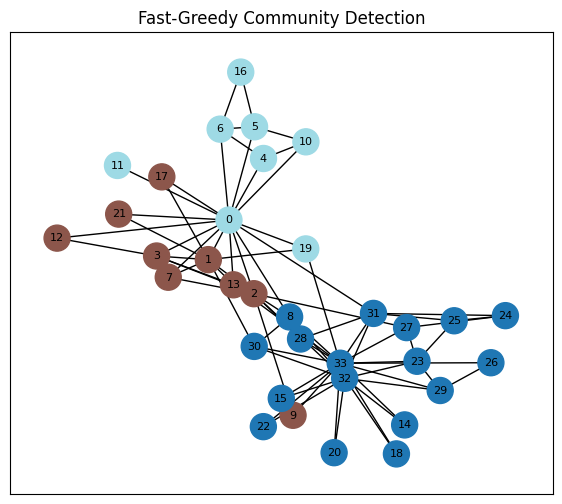

In [10]:
plot_communities(G, louvain_labels, "Louvain Community Detection")
plot_communities(G, fg_labels, "Fast-Greedy Community Detection")


In [11]:
def purity_score(true_labels, predicted_labels):
    N = len(true_labels)
    true_classes = {}
    pred_classes = {}

    # group nodes by true class
    for node, c in true_labels.items():
        true_classes.setdefault(c, []).append(node)

    # group nodes by predicted class
    for node, c in predicted_labels.items():
        pred_classes.setdefault(c, []).append(node)

    # compute purity
    purity = 0
    for c in true_classes:
        max_overlap = 0
        for k in pred_classes:
            overlap = len(set(true_classes[c]).intersection(pred_classes[k]))
            max_overlap = max(max_overlap, overlap)
        purity += max_overlap

    return purity / N


In [12]:
def rand_index(true_labels, pred_labels):
    TP = TN = FP = FN = 0
    nodes = list(true_labels.keys())

    for u, v in combinations(nodes, 2):
        same_true = (true_labels[u] == true_labels[v])
        same_pred = (pred_labels[u] == pred_labels[v])

        if same_true and same_pred:
            TP += 1
        elif not same_true and not same_pred:
            TN += 1
        elif not same_true and same_pred:
            FP += 1
        elif same_true and not same_pred:
            FN += 1

    return (TP + TN) / (TP + TN + FP + FN)


In [13]:
l_purity = purity_score(gt_labels, louvain_labels)
fg_purity = purity_score(gt_labels, fg_labels)

l_RI = rand_index(gt_labels, louvain_labels)
fg_RI = rand_index(gt_labels, fg_labels)

print("Louvain Purity:", l_purity)
print("Fast Greedy Purity:", fg_purity)
print("Louvain RI:", l_RI)
print("Fast Greedy RI:", fg_RI)


Louvain Purity: 0.6470588235294118
Fast Greedy Purity: 0.7058823529411765
Louvain RI: 0.7361853832442068
Fast Greedy RI: 0.786096256684492


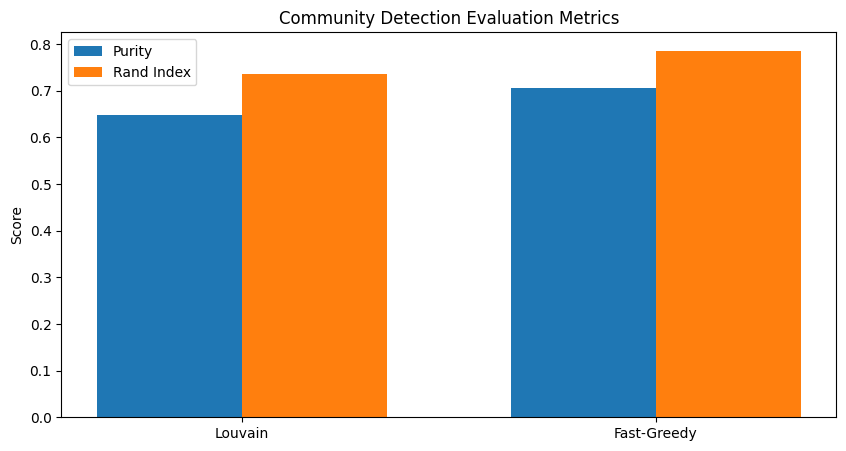

In [14]:
methods = ["Louvain", "Fast-Greedy"]
purity_scores = [l_purity, fg_purity]
ri_scores = [l_RI, fg_RI]

x = np.arange(len(methods))
width = 0.35

plt.figure(figsize=(10, 5))
plt.bar(x - width/2, purity_scores, width, label="Purity")
plt.bar(x + width/2, ri_scores, width, label="Rand Index")
plt.xticks(x, methods)
plt.ylabel("Score")
plt.title("Community Detection Evaluation Metrics")
plt.legend()
plt.show()
